# Load Model

In [101]:
import os
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from attack import Attack
sys.path.append('./attacks')
from fgsm import FGSM
from pgd import PGD

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [134]:
mean, std = [0.4914, 0.4822, 0.4465 ], [ 0.2023, 0.1994, 0.2010 ], 

train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])


cifar10_train = dsets.CIFAR10(root='../data', train=True,
                                       download=True, transform=train_transform)
cifar10_test  = dsets.CIFAR10(root='../data', train=False,
                                       download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=50,
                                         shuffle=True, num_workers=1)

test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=50,
                                        shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
#標準化、逆標準化
class normalizer: #平均0、分散1にする
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self,images):
        im = torch.zeros_like(images)
        im[:, 0, :, :] = (images[:, 0, :, :] - self.mean[0]) / self.std[0]
        im[:, 1, :, :] = (images[:, 1, :, :] - self.mean[1]) / self.std[1]
        im[:, 2, :, :] = (images[:, 2, :, :] - self.mean[2]) / self.std[2]
        del images
        return im

class inv_normalizer: #また、[0,1]に戻す（clampして計算揺れをなくす）
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self,images):
        im = torch.zeros_like(images)
        im[:, 0, :, :] = images[:, 0, :, :] * self.std[0] + self.mean[0]
        im[:, 1, :, :] = images[:, 1, :, :] * self.std[1] + self.mean[1]
        im[:, 2, :, :] = images[:, 2, :, :] * self.std[2] + self.mean[2]
        del images
        return torch.clamp(im, 0, 1)
    
norm = normalizer(mean, std)
inv_norm = inv_normalizer(mean, std)

def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (20, 50))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [6]:
def generate_opt_means(C, p, L): 
    """
    input
        C = constant value
        p = dimention of feature vector
        L = class number
    """
    opt_means = np.zeros((L, p))
    opt_means[0][0] = 1
    for i in range(1,L):
        for j in range(i): 
            opt_means[i][j] = - (1/(L-1) + np.dot(opt_means[i],opt_means[j])) / opt_means[j][j]
        opt_means[i][i] = np.sqrt(1 - np.linalg.norm(opt_means[i])**2)
    for k in range(L):
        opt_means[k] = C * opt_means[k]
        
    return opt_means

In [158]:
class MM_LDA(nn.Module):
    def __init__(self, C, n_dense, class_num, device, Normalize=False):
        super().__init__()
        self.C = C
        self.class_num = class_num
        opt_means = generate_opt_means(C, n_dense, class_num)
        self.mean_expand = torch.tensor(opt_means).unsqueeze(0).double().to(device) # (1, num_class, num_dense)
        self.Normalize = Normalize
        
    def forward(self, x):
#         print('x', x, x.shape)
        b, p = x.shape # batch_size, num_dense
        L = self.class_num
        if self.Normalize: # 正規化する
            x = (x / (torch.norm(x, p=2, dim=1, keepdim=True) + 1e-10)) * self.C
#             print(torch.norm(x, p=2, dim=1, keepdim=True))
            
        x_expand =  x.repeat(1,L).view(b, L, p).double() # (batch_size, num_class, num_dense)

        logits = - torch.sum((x_expand - self.mean_expand)**2, dim=2) # (batch_size, num_class)
#         print('x-mean',x_expand - self.mean_expand)
#         print('logits', logits, logits.shape)
 
        return logits

# Test Code

In [163]:
def test_on_normal_data(model):
    model.eval()

    correct = 0
    total = 0

    for images, labels in test_loader:

        images = images.cuda()
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Accuracy of Clean images: %f %%' % (100 * float(correct) / total))

In [173]:
def test_on_AEs(model, attack='PGD'):
    model.eval()

    correct = 0
    total = 0

    fgsm_attack = FGSM(model, eps=0.12) #Benchmarking Adversarial Robustness on Image Classificationの設定
    pgd_attack = PGD(model, eps=8/255, alpha=2/255, steps=10)

    for images, labels in test_loader:
        
        if attack=='PGD':
            adv_images = pgd_attack(images, labels ).cuda()
        elif attack=='FGSM':
            adv_images = fgsm_attack(images, labels ).cuda()
    #     adv_images_norm = norm(adv_images)

        outputs = model(adv_images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Accuracy on Adversarial images: %f %%' % (100 * float(correct) / total))

In [174]:
def show_examples(model, attack='PGD', eps=8/255):
    images, labels = iter(test_loader).next()
    t = 20
    idx = list(range(t,t+8))

    print('Normal')
    imshow(torchvision.utils.make_grid(images[idx], normalize=True), [classes[int(i)] for i in labels[idx]])
    _ , pred_labels = torch.max(model(images.cuda()), 1)
    print('Predicted Label:', [classes[int(i)] for i in pred_labels[idx]])

    print('------------------------------------')

    fgsm_attack = FGSM(model, eps=eps)
    pgd_attack = PGD(model, eps=eps, alpha=2/255, steps=10)

    if attack=='PGD':
        adv_images = pgd_attack(images, labels )
    elif attack=='FGSM':
        adv_images = fgsm_attack(images, labels )
    #norm_adv_images = norm(adv_images)

    print('Adversarial')
    imshow(torchvision.utils.make_grid(adv_images.cpu().data[idx], normalize=True), [classes[int(i)] for i in labels[idx]])

    outputs = model(adv_images.cuda())
    _, pred_labels = torch.max(outputs, 1)

    print('Predicted Label:', [classes[int(i)] for i in pred_labels[idx]])

# Test

## 1. MMC

In [167]:
# MMC

file_name = './exps/checkpoint_resnet34_MMC_norm/ckpt.pth'

model = models.resnet34(pretrained=False)
model.fc = nn.Linear(512,256) # use_dense
# MM_LDA 
C, n_dense, class_num = 10, 256, 10
mm_lda_layer = MM_LDA(C, n_dense, class_num, device, Normalize=True) 
#activation = nn.Softmax(1)
model = nn.Sequential(model, mm_lda_layer) # , activation) # テスト時はsoftmaxするため
model = model.to(device)

checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

Accuracy of Clean images: 80.680000 %
Accuracy on Adversarial images: 76.940000 %
Normal


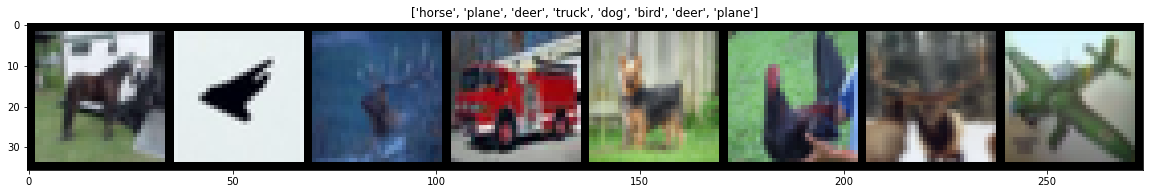

Predicted Label: ['horse', 'plane', 'deer', 'truck', 'deer', 'bird', 'deer', 'deer']
------------------------------------
Adversarial


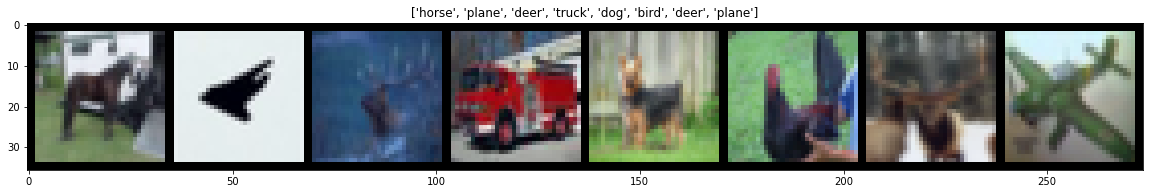

Predicted Label: ['horse', 'plane', 'deer', 'truck', 'deer', 'cat', 'deer', 'deer']
Accuracy on Adversarial images: 77.050000 %
Normal


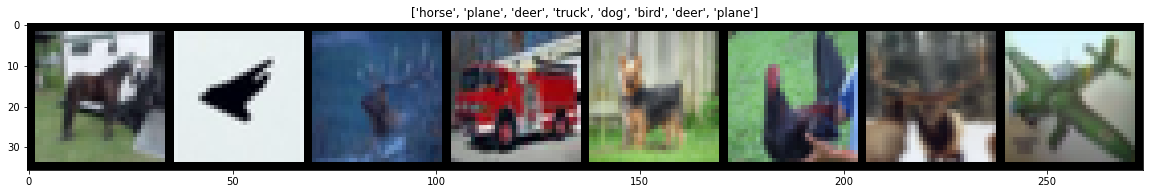

Predicted Label: ['horse', 'plane', 'deer', 'truck', 'deer', 'bird', 'deer', 'deer']
------------------------------------
Adversarial


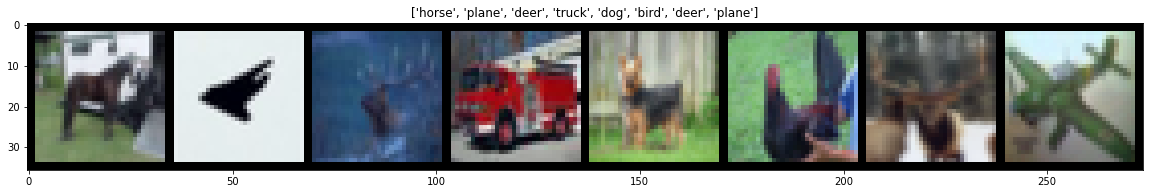

Predicted Label: ['horse', 'plane', 'deer', 'truck', 'deer', 'cat', 'deer', 'deer']


In [168]:
test_on_normal_data(model)
for attack in ['PGD','FGSM']:
    print(attack)
    test_on_AEs(model, attack=attack)
    show_examples(model, attack=attack)

## 2.MM_LDA

In [178]:
# MM_LDA

file_name = './exps/checkpoint_resnet34_MMLDA/ckpt.pth'

model = models.resnet34(pretrained=False)
model.fc = nn.Linear(512,256) # use_dense
# MM_LDA 
C, n_dense, class_num = 100, 256, 10
mm_lda_layer = MM_LDA(C, n_dense, class_num, device, Normalize=True) 
#activation = nn.Softmax(1)
model = nn.Sequential(model, mm_lda_layer) # , activation) # テスト時はsoftmaxするため
model = model.to(device)

checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
test_on_normal_data(model)
for attack in ['PGD','FGSM']:
    print(attack)
    test_on_AEs(model, attack=attack)
    show_examples(model, attack=attack)

Accuracy of Clean images: 62.290000 %
PGD
